In [2]:
import pandas as pd
import numpy as np
import GOES
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
import xarray as xr
import custom_color_palette as ccp
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter


In [197]:
GOES.download('goes16', 'ABI-L2-CMIPF',
              DateTimeIni = '20240317-090000', DateTimeFin = '20240317-091000',
              channel = ['13'], path_out='d:\\IMGRC\\CICLO V\\GOES\\',rename_fmt = '%Y%m%d%H%M')

Files:
  OR_ABI-L2-CMIPF-M6C13_G16_s202403170900.nc 100% 23.0MB 2s


['d:\\IMGRC\\CICLO V\\GOES\\OR_ABI-L2-CMIPF-M6C13_G16_s202403170900.nc']

In [3]:
path = 'd:\\IMGRC\\CICLO V\\GOES\\'
file = 'OR_ABI-L2-CMIPF-M6C13_G16_s202403170900.nc'

# Abrir el dataset
ds = GOES.open_dataset(path+file)

# Definir el dominio (zona de estudio)
domain = [-74.64,-69.91,-15.71,-10.66]

CMI, LonCor, LatCor = ds.image('CMI', lonlat='corner', domain=domain)

In [12]:
tb=CMI.data
print(f'El array es:\n {tb}')
print('')
print(f'La forma del array es {tb.shape}')
print('')

# Hacemos un reshape para que se pueda trabajar con el Clustering
rtb=tb.reshape(-1,1)
print(f'La nueva forma del array es: {np.shape(rtb)}')
print('')

# Comprobamos
print(rtb)


El array es:
 [[287.4997  287.06952 287.00806 ... 254.68362 251.11932 247.61649]
 [287.31534 287.31534 287.43823 ... 253.02438 250.25897 245.34271]
 [287.3768  287.4997  287.56116 ... 249.39862 247.49359 242.27005]
 ...
 [287.80695 288.1757  288.72876 ... 275.14758 274.4716  273.97995]
 [286.88516 287.4997  287.99133 ... 275.33194 273.7956  274.22577]
 [286.27063 286.51645 287.00806 ... 277.7286  274.0414  271.8291 ]]

La forma del array es (268, 257)

La nueva forma del array es: (68876, 1)

[[287.4997 ]
 [287.06952]
 [287.00806]
 ...
 [277.7286 ]
 [274.0414 ]
 [271.8291 ]]


In [13]:
SCC=[]
for i in range (1,18):
    kmeans_test=KMeans(n_clusters=i, init='k-means++',random_state=2812,n_init='auto')
    kmeans_test.fit(rtb)
    SCC.append(kmeans_test.inertia_)

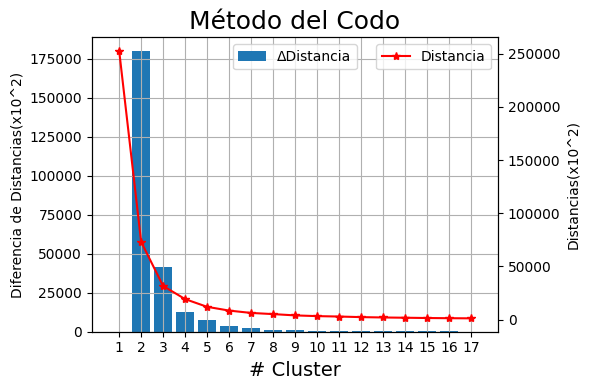

In [208]:
scc_acu=[0]
for i in range(1,len(SCC)):
    scc_acu=np.append(scc_acu,SCC[i]-SCC[i-1])
scc_acu=-scc_acu
fig,ax1= plt.subplots(figsize=(6,4))
plot1=ax1.bar(np.arange(1,18),scc_acu/10**2)
ax1.set_xticks(np.arange(1,18,1))
ax1.grid()
ax1.set_xlabel('# Cluster', size=14)
ax1.set_ylabel('Diferencia de Distancias(x10^2)')
ax2=ax1.twinx()
plot2=ax2.plot(np.arange(1,18), np.array(SCC)/10**2,'r*-')
ax2.set_ylabel('Distancias(x10^2)')
plt.title('Método del Codo',size=18)
ax1.legend(plot1,['ΔDistancia'],loc='upper center')
ax2.legend(plot2,['Distancia'],loc='upper right')
plt.tight_layout()

In [15]:
kmeans4=KMeans(n_clusters=4, init = 'k-means++',random_state=2812,n_init='auto')
kmeans4.fit(rtb)

KMeans(n_clusters=4, random_state=2812)

In [17]:
# Vemos los centros de cada cluster
print(kmeans4.cluster_centers_)
print('')
# Vemos los Labels
print(kmeans4.labels_)
print('')
# Volvemos el array a su forma original
clus=kmeans4.labels_.reshape(268, 257)
print(clus)

[[242.96265]
 [278.7058 ]
 [222.50722]
 [262.0801 ]]

[1 1 1 ... 1 1 1]

[[1 1 1 ... 3 0 0]
 [1 1 1 ... 3 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


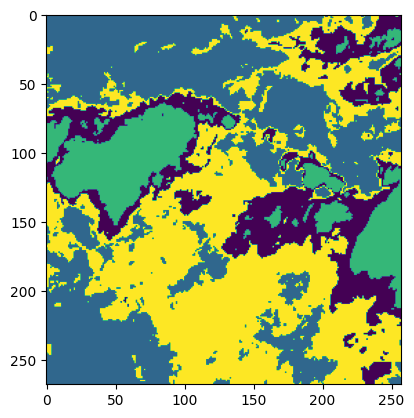

In [18]:
plt.imshow(clus)

In [19]:
sat = ds.attribute('platform_ID')
band = ds.variable('band_id').data[0]
wl = ds.variable('band_wavelength').data[0]

In [20]:
lower_colors = ['maroon','red','darkorange','#ffff00','forestgreen','cyan','royalblue',(148/255,0/255,211/255)]
lower_palette = [lower_colors, ccp.range(180.0,240.0,1.0)]

upper_colors = plt.cm.Greys
upper_palette = [upper_colors, ccp.range(240.0,330.0,1.0), [ccp.range(180.0,330.0,1.0),240.0,330.0]]

cmap, cmticks, norm, bounds = ccp.creates_palette([lower_palette, upper_palette], extend='both')

ticks = ccp.range(180,330,10)

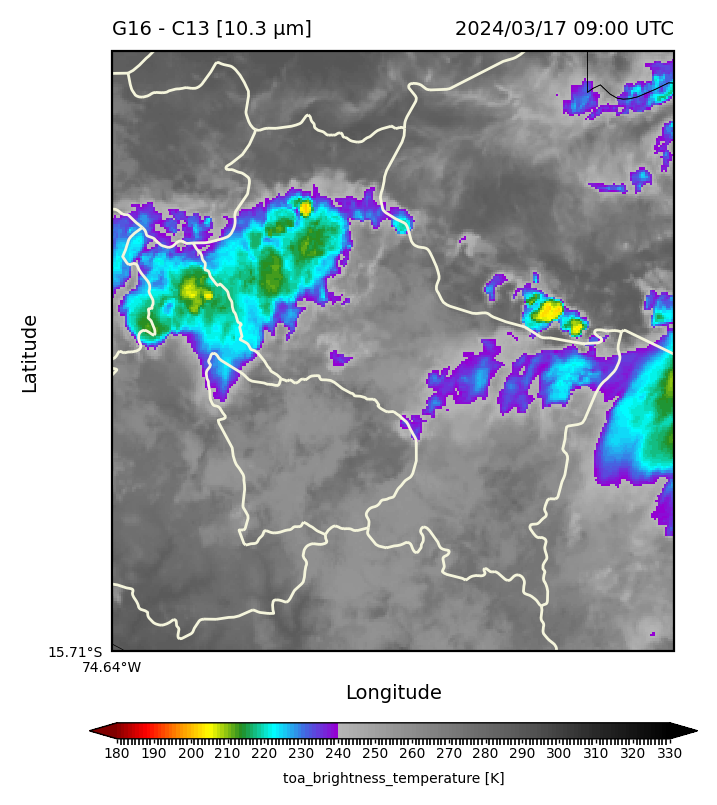

In [ ]:
lon_cen = 360.0+(domain[0]+domain[1])/2.0
fig = plt.figure('map', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.16, 0.80, 0.75], projection=ccrs.PlateCarree(lon_cen))
l = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax.add_feature(l, edgecolor='black', linewidth=0.25)
img = ax.pcolormesh(LonCor.data, LatCor.data, CMI.data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cb = plt.colorbar(img, ticks=ticks, orientation='horizontal', extend='both', cax=fig.add_axes([0.12, 0.05, 0.76, 0.02]))
cb.ax.tick_params(labelsize=5, labelcolor='black', width=0.5, length=1.5, direction='out', pad=1.0)
cb.set_label(label='{} [{}]'.format(CMI.standard_name, CMI.units), size=5, color='black', weight='normal')
cb.outline.set_linewidth(0.5)
ax.set_title('{} - C{:02d} [{:.1f} μm]'.format(sat,band, wl), fontsize=7, loc='left')
ax.set_title(CMI.time_bounds.data[0].strftime('%Y/%m/%d %H:%M UTC'), fontsize=7, loc='right')
dx = 15
xticks = np.arange(domain[0], domain[1]+dx, dx)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(dateline_direction_label=True))
ax.set_xlabel('Longitude', color='black', fontsize=7, labelpad=3.0)
dy = 15
yticks = np.arange(domain[2], domain[3]+dy, dy)
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_ylabel('Latitude', color='black', fontsize=7, labelpad=3.0)
ax.tick_params(left=True, right=True, bottom=True, top=True, labelleft=True, labelright=False, labelbottom=True, labeltop=False,
               length=0.0, width=0.05, labelsize=5.0, labelcolor='black')
ax.gridlines(xlocs=xticks, ylocs=yticks, alpha=0.6, color='gray', draw_labels=False, linewidth=0.25, linestyle='--')
ax.set_extent([domain[0]+360.0, domain[1]+360.0, domain[2], domain[3]], crs=ccrs.PlateCarree())
departamentos = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='10m', facecolor='none')
ax.add_feature(departamentos, edgecolor='beige', linewidth=1)
plt.show()

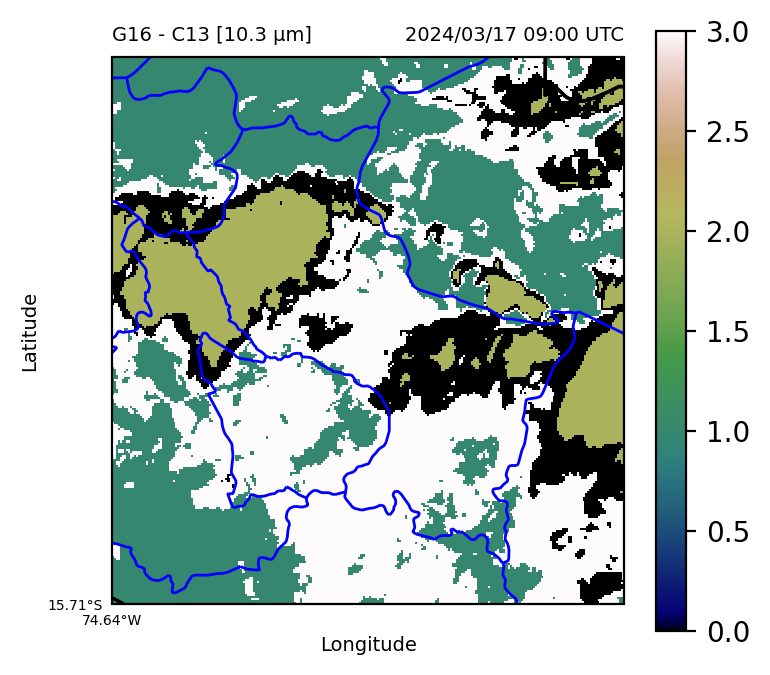

In [21]:
lon_cen = 360.0+(domain[0]+domain[1])/2.0
fig = plt.figure('map', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.16, 0.80, 0.75], projection=ccrs.PlateCarree(lon_cen))
l = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax.add_feature(l, edgecolor='black', linewidth=1.25)
img = ax.pcolormesh(LonCor.data, LatCor.data, clus, cmap='gist_earth', transform=ccrs.PlateCarree())
cb = plt.colorbar(img)
ax.set_title('{} - C{:02d} [{:.1f} μm]'.format(sat,band, wl), fontsize=7, loc='left')
ax.set_title(CMI.time_bounds.data[0].strftime('%Y/%m/%d %H:%M UTC'), fontsize=7, loc='right')
dx = 15
xticks = np.arange(domain[0], domain[1]+dx, dx)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(dateline_direction_label=True))
ax.set_xlabel('Longitude', color='black', fontsize=7, labelpad=3.0)
dy = 15
yticks = np.arange(domain[2], domain[3]+dy, dy)
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_ylabel('Latitude', color='black', fontsize=7, labelpad=3.0)
ax.tick_params(left=True, right=True, bottom=True, top=True,
               labelleft=True, labelright=False, labelbottom=True, labeltop=False,
               length=0.0, width=0.05, labelsize=5.0, labelcolor='black')
ax.gridlines(xlocs=xticks, ylocs=yticks, alpha=0.6, color='gray',
             draw_labels=False, linewidth=0.25, linestyle='--')
ax.set_extent([domain[0]+360.0, domain[1]+360.0, domain[2], domain[3]], crs=ccrs.PlateCarree())
departamentos = NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='10m', facecolor='none')
ax.add_feature(departamentos, edgecolor='blue', linewidth=1)
plt.show()

In [23]:
centros = kmeans4.cluster_centers_
clusters_con_etiquetas = [(f"Cluster {i}", centro[0]) for i, centro in enumerate(centros)]
clusters_ordenados = sorted(clusters_con_etiquetas, key=lambda x: x[1])
for etiqueta, valor in clusters_ordenados:
    print(f"{etiqueta}: {valor:.2f}")

Cluster 2: 222.51
Cluster 0: 242.96
Cluster 3: 262.08
Cluster 1: 278.71
